In [18]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import irrevolutions.utils.postprocess as pp
# import plots
import os

import eigenspace as eig

In [19]:

def l2_norm(components):
    """
    Compute the L2 norm of a vector field defined by components on their respective domains.

    Parameters:
        components (list): List of tuples (x, f) where x is the mesh coordinates and f is the field values.

    Returns:
        float: L2 norm of the vector field.
    """
    norms = []

    for x, f in components:
        # Compute the square of the field values
        squared_values = f**2

        # Compute the integral using the trapezoidal rule
        integral = np.trapz(squared_values, x)

        # Take the square root to get the L2 norm
        component_norm = np.sqrt(integral)
        norms.append(component_norm)

    # Compute the vector norm by summing the squared norms and taking the square root
    vector_norm = np.sqrt(np.sum(np.array(norms)**2))

    return vector_norm

In [22]:
import os
import yaml
import matplotlib.pyplot as plt

def load_parameters(directory):
    parameters_file = os.path.join(directory, 'parameters.yaml')
    if os.path.exists(parameters_file):
        with open(parameters_file, 'r') as f:
            parameters = yaml.safe_load(f)
        return parameters
    else:
        return None
    
def load_signature(directory):
    signature_file = os.path.join(directory, 'signature.md5')
    if os.path.exists(signature_file):
        with open(signature_file, 'r') as f:
            signature = yaml.safe_load(f)
        return signature
    else:
        return None
    
def compute_contour(a_values, bc_square_values):
    a, bcsq = np.meshgrid(a_values, bc_square_values)
    D_values = (np.pi**2 * a / bcsq)**(1/3)
    return a, bcsq, D_values

def plot_phase_space(rootdir):
    successful_points = []
    unsuccessful_points = []
    points_count = {}

    for subdir, _, _ in os.walk(rootdir):
        parameters = load_parameters(subdir)
        if parameters is not None:
            a = parameters.get('model', {}).get('a')
            b = parameters.get('model', {}).get('b')
            c = parameters.get('model', {}).get('c')

            # Check if the computation is successful based on the existence of mode_shapes_data.npz
            success_file = os.path.join(subdir, 'mode_shapes_data.npz')
            datapoint = (np.pi**2 * a, b*c**2)
            
            if os.path.exists(success_file):
                successful_points.append(datapoint)
            else:
                unsuccessful_points.append(datapoint)

            points_count[datapoint] = points_count.get(datapoint, 0) + 1

    for datapoint, count in points_count.items():
        # plt.scatter(*datapoint, label=f'Multiplicity: {count}', marker='')
        # plt.scatter(*datapoint, marker='')
        plt.annotate(f'\#{count}', datapoint, textcoords="offset points", xytext=(0, -15), ha='center')

    # Create the plot
    plt.scatter(*zip(*unsuccessful_points), label='Unsuccessful', marker='x')
    plt.scatter(*zip(*successful_points), label='Successful', marker='.', s=200)
    plt.xlabel('$\pi^2 a$')
    plt.ylabel('$bc^2$')
    plt.legend()
    a_values = np.linspace(0, 100, 100)
    bc_sq_values = np.linspace(0, 100, 100)
    a, bc_sq, D_values = compute_contour(a_values, bc_sq_values)
    plt.contour(bc_sq, a , D_values, levels=5, colors='black', linestyles='dashed')

    plt.show()

# Example usage
    plot_phase_space(dirroot)


In [23]:
experiment = '../../test/output/rayleigh-benchmark/MPI-1/bef047fb68f6bc3b5feb6b2f634b15fc'
experiment = '../../test/output/rayleigh-benchmark/MPI-1/ff9c4acbaf25a77cb9e99342154bed50'

params, data, signature = pp.load_data(experiment)


File 'time_data.json' not found. Handle this case accordingly.


In [24]:
modes_data = np.load(os.path.join(experiment, 'mode_shapes_data.npz'), allow_pickle=True)


In [25]:
mode = pp.read_mode_data_from_npz(modes_data, time_step=0, num_modes=1, num_points=10)


## Rayleigh benchmark

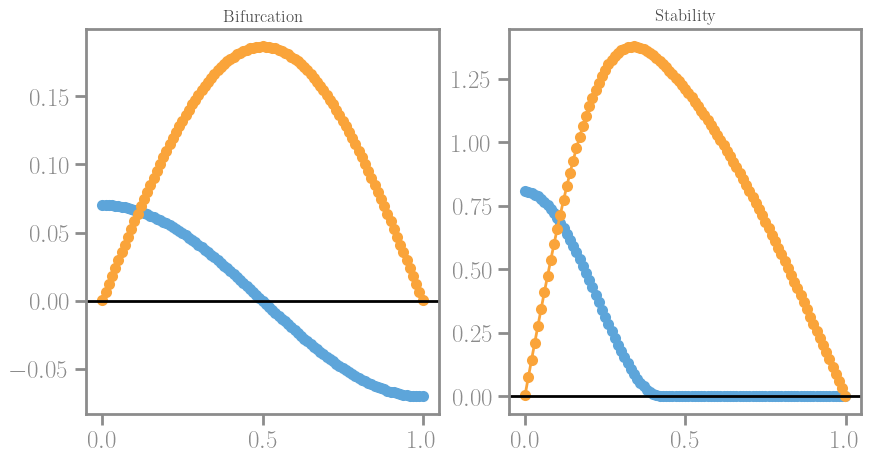

In [32]:
_fig, _axes = pp.plot_fields_for_time_step(mode)

In [26]:
def plot_profile_comparison(parameters, mode, idx=[1, 1], reverse = False):

    _fig, _axes = pp.plot_fields_for_time_step(mode)
    _axes[0].set_title('Eigenvectors (bifurcation problem)')
    _axes[1].set_title('Eigenvectors (stability problem)')
    _parameters = f'a = {parameters.get("a"):.2f}, b = {parameters.get("b"):.2f}, c = {parameters.get("c"):.2f}'
    _fig.suptitle(f"Rayleigh eigenproblem with parameters {_parameters}")

    coeff_v = l2_norm([
        (mode['mesh'], mode['fields']['bifurcation_v']),
        (mode['mesh'], mode['fields']['bifurcation_β'])
        ])

    coeff_k = l2_norm([
        (mode['mesh'], mode['fields']['stability_β'])
        ])

    eigenspace_v, _normalisation_v = eig.solve_eigenspace_vector(parameters, idx=idx[0])
    eigenspace_k, _normalisation_k = eig.solve_eigenspace_cone(parameters, idx=idx[1])

    v, β = eigenspace_v["v"], eigenspace_v["β"]

    x_values = np.linspace(0, 1, 100)
    v_function = sp.lambdify('x', v)
    β_function = sp.lambdify('x', β)

    v_values = [v_function(x) for x in x_values]
    β_values = [β_function(x) for x in x_values]

    _axes[0].plot(x_values, np.array(β_values)*coeff_v, label=r'$\beta(x)$', c='k')
    _axes[0].plot(x_values, np.array(v_values)*coeff_v, label=r'$v(x)$', c='k', linestyle='--')

    _axes[0].legend()
    
    v, β = eigenspace_k["v"], eigenspace_k["β"]
    D = eigenspace_k["D"]
    x_values = np.linspace(0, 1, 100)
    v_function = sp.lambdify('x', v)
    β_function = sp.lambdify('x', β)
    v_values = [v_function(x) for x in x_values]
    if reverse:
        β_values = [β_function(1-x) for x in x_values]
    else:
        β_values = [β_function(x) for x in x_values]

    _axes[1].plot(x_values, np.array(β_values)*coeff_k, label=r'$\beta(x)$', c='k')
    _axes[1].set_xticks([0, float(sp.N(D))], [0, "$D$"])
    _axes[1].legend()

    return _fig, _axes

File 'time_data.json' not found. Handle this case accordingly.
case 2
[{x, A}, {x, A}]
sqrt(2*A**2/pi**2 + A**2/2) True False
depends_on_A
case 2
sqrt(0.184201574932019*sin(1.0*pi**1.0)*cos(1.0*pi**1.0)/pi**0.333333333333333 + 0.184201574932019*pi**0.666666666666667*sin(1.0*pi**1.0)**2 + 0.736806299728077*sin(1.0*pi**1.0)/pi**0.333333333333333 + 0.184201574932019*pi**0.666666666666667*cos(1.0*pi**1.0)**2 + 0.368403149864039*pi**0.666666666666667)*sqrt(C**2)
depends_on_C


(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Eigenvectors (bifurcation problem)'}>,
        <Axes: title={'center': 'Eigenvectors (stability problem)'}>],
       dtype=object))

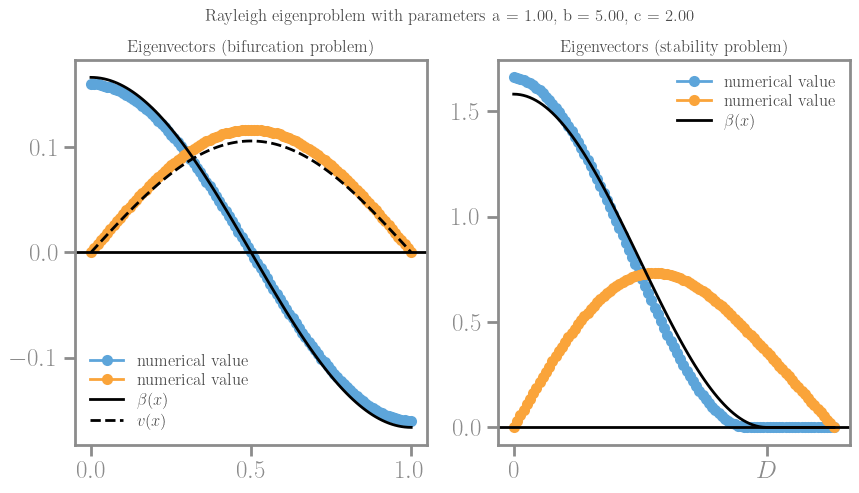

In [27]:
experiment = '../../test/output/rayleigh-benchmark/MPI-1/2f6fb02e066c6e61b2680447a53b61df'
modes_data = np.load(os.path.join(experiment, 'mode_shapes_data.npz'), allow_pickle=True)
mode = pp.read_mode_data_from_npz(modes_data, time_step=0, num_modes=1, num_points=10)

params, data, signature = pp.load_data(experiment)

a = params['model']['a']
b = params['model']['b']
c = params['model']['c']

parameters = {"a": a, "b": b, "c": c}

plot_profile_comparison(parameters, mode, idx=[1, 0], reverse=False)

## Parametric Rayleigh benchmark

In [70]:
import os
cwd = os.getcwd()
path_components = cwd.split(os.path.sep)
path_components = path_components[0:-2]
dirroot =  '/' + os.path.join(*path_components, 'test', 'output', 'rayleigh-benchmark-parametric', 'MPI-1')

!ls $dirroot


09076beeea49a74b65d644c11839a44e 7afebd331ee98a64b791b63fbc8ad472
0f67f4193a71a9bf6c675fbfbcf1d20d 8bfe52ddf33e78f00dcf06fd64c8e224
10eeb7e510f7d9acd9dd9308d181efeb ae5552e2d6ee5b4e1c893e54afd34fd3
2e3199d4d028afc46d07481cccc20842 c1a4dc86c067d904f18a359e5a9e9872
3c8264e098e3d65e4644010f2f4579d9 c2b5b729950d97a148bbee24b2dbcd31
4a6cabbcba72ee55b02ddea270cb7b19 e677ff5ecbcf45d08d72b1216ae8ac3c
551c5c9da4307fe423c017ad884fe6a2 fbbafee8a0d2b4b091b87b6ecd796e34
7597f526ad2930b5e9fb98c1888985a9


In [71]:
for subdir, dirs, files in os.walk(dirroot):
    if not os.path.isfile(subdir + "/signature.md5"):
        continue
    print(subdir)
    modes_data = np.load(os.path.join(subdir, 'mode_shapes_data.npz'), allow_pickle=True)
    mode = pp.read_mode_data_from_npz(modes_data, time_step=0, num_modes=1, num_points=-1)
    params, data, signature = pp.load_data(subdir)

    # params, data, signature = pp.load_data(subdir)
    # cone_data = data["solver_KS_data"][[isinstance(d["iterations"], int) for d in data["solver_KS_data"]]]
    # _offset = sum([not isinstance(d["iterations"], int) for d in data["solver_KS_data"]])

    # _ell = params['model']['ell']
    # print(f" scaling = {params['stability']['cone']['scaling']}")
    # pd.DataFrame(cone_data)
    # for entry in cone_data:
        # plt.plot(entry["lambda_0"])


/Users/kumiori3/Documents/WIP/Nature/mec647/test/output/rayleigh-benchmark-parametric/MPI-1/7597f526ad2930b5e9fb98c1888985a9
File 'time_data.json' not found. Handle this case accordingly.
/Users/kumiori3/Documents/WIP/Nature/mec647/test/output/rayleigh-benchmark-parametric/MPI-1/09076beeea49a74b65d644c11839a44e
File 'time_data.json' not found. Handle this case accordingly.
/Users/kumiori3/Documents/WIP/Nature/mec647/test/output/rayleigh-benchmark-parametric/MPI-1/ae5552e2d6ee5b4e1c893e54afd34fd3
File 'time_data.json' not found. Handle this case accordingly.
/Users/kumiori3/Documents/WIP/Nature/mec647/test/output/rayleigh-benchmark-parametric/MPI-1/4a6cabbcba72ee55b02ddea270cb7b19
File 'time_data.json' not found. Handle this case accordingly.
/Users/kumiori3/Documents/WIP/Nature/mec647/test/output/rayleigh-benchmark-parametric/MPI-1/10eeb7e510f7d9acd9dd9308d181efeb
File 'time_data.json' not found. Handle this case accordingly.
/Users/kumiori3/Documents/WIP/Nature/mec647/test/output/rayl

FileNotFoundError: [Errno 2] No such file or directory: '/Users/kumiori3/Documents/WIP/Nature/mec647/test/output/rayleigh-benchmark-parametric/MPI-1/6d4ce0926719f298a6e81a82f63ae0e9/mode_shapes_data.npz'

In [4]:
import numpy as np

# Example usage
mesh_coordinates = np.linspace(0, 1, 100)  # Adjust the number of points as needed
field_values = np.sin(np.pi * mesh_coordinates)  # Replace with your field values
field_values = np.sin(np.sin(np.pi * mesh_coordinates))  # Replace with your field values
# field_values = np.ones(len(mesh_coordinates))  # Replace with your field values
result = l2_norm([(mesh_coordinates, field_values)])
print(result)


0.6229402944338904


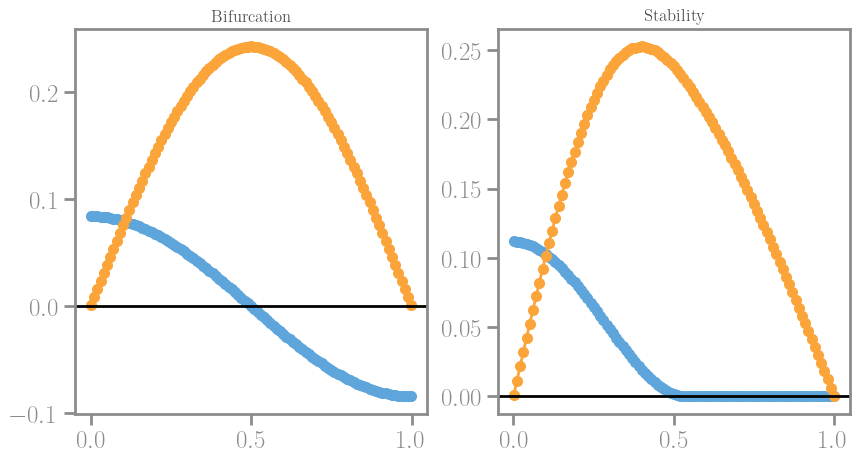

In [27]:
mode = pp.read_mode_data_from_npz(modes_data, time_step=0, num_modes=1, num_points=10)
_fig, _axes = pp.plot_fields_for_time_step(mode)

In [28]:
l2_norm([
    (mode['mesh'], mode['fields']['bifurcation_v']),
    (mode['mesh'], mode['fields']['bifurcation_β'])
    ])

0.18171983239793219

In [29]:
max(mode['fields']['bifurcation_v'])

0.2430757059374186

In [30]:
params

{'geometry': {'Lx': 1.0,
  'Ly': 0.1,
  'N': 10,
  'geom_type': 'infinite-dimensional-unit-test',
  'geometric_dimension': 2,
  'lc': 0.02,
  'mesh_size_factor': 4},
 'loading': {'max': 1.001, 'min': 0, 'steps': 10},
 'model': {'a': 1, 'b': 1, 'c': 8, 'model_dimension': 1, 'model_type': '1D'},
 'solvers': {'damage': {'prefix': 'damage',
   'snes': {'ksp_type': 'preonly',
    'pc_factor_mat_solver_type': 'mumps',
    'pc_type': 'lu',
    'snes_atol': 1e-08,
    'snes_linesearch_type': 'basic',
    'snes_max_it': 50,
    'snes_monitor': '',
    'snes_rtol': 1e-08,
    'snes_type': 'vinewtonrsls'},
   'tao': {'ksp_rtol': '1e-6',
    'pc_type': 'lu',
    'tao_catol': 0.0,
    'tao_crtol': 0.0,
    'tao_gatol': 1e-08,
    'tao_gpcg_maxpgits': 50,
    'tao_grtol': 1e-08,
    'tao_gttol': 1e-08,
    'tao_ls_ftol': '1e-5',
    'tao_ls_gtol': '1e-5',
    'tao_ls_rtol': '1e-5',
    'tao_ls_stepmax': '1e6',
    'tao_ls_stepmin': '1e-8',
    'tao_max_it': 100,
    'tao_monitor': '',
    'tao_stept

## From the book of the numbers...

In [24]:
eigenspace_v, _normalisation_v = eig.solve_eigenspace_vector(parameters)
eigenspace_k, _normalisation_k = eig.solve_eigenspace_cone(parameters)


case 2
[{x, A}, {x, A}]
sqrt(A**2/2 + 32*A**2/pi**2) True False
depends_on_A
case 2
sqrt(0.125*sin(1.0*pi**1.0)*cos(1.0*pi**1.0)/pi**0.333333333333333 + 0.125*pi**0.666666666666667*sin(1.0*pi**1.0)**2 + 0.5*sin(1.0*pi**1.0)/pi**0.333333333333333 + 0.125*pi**0.666666666666667*cos(1.0*pi**1.0)**2 + 0.25*pi**0.666666666666667)*sqrt(C**2)
depends_on_C


In [25]:
eigenspace_v, _normalisation_v

({'v': -8*sqrt(2)*sin(pi*x)/sqrt(pi**2 + 64),
  'β': -sqrt(2)*pi*cos(pi*x)/sqrt(pi**2 + 64),
  'D': 0},
 {A: -sqrt(2)*pi/sqrt(pi**2 + 64)})

In [26]:
eigenspace_k, _normalisation_k

({'v': 0,
  'β': Piecewise((1.11498170631978*cos(4.0*pi**0.333333333333333*x) + 1.11498170631978, (x >= 0) & (x <= 0.25*pi**0.666666666666667)), (0, True)),
  'D': 0.25*pi**0.666666666666667},
 {C: 1.11498170631978})

In [37]:

def solve_eigenspace_vector(parameters, idx = 0):
    """
    Solve for the eigenspace in a vector space.

    Parameters:
        parameters (dict): A dictionary containing the values for 'a', 'b', and 'c'.
        idx (int): Index to choose the appropriate solution in case of multiple solutions.

    Returns:
        dict: A dictionary containing 'v', 'β', and 'D'.
    """
    x = sp.symbols('x', real=True)
    v = sp.Function('v', real=True)(x)
    β = sp.Function('β', real=True)(x)
    C, A = sp.symbols('C A')
    
    a = parameters["a"]
    b = parameters["b"]
    c = parameters["c"]    
    
    if b * c**2 < sp.pi**2 * a:
        print('case 1')
        _subs = {A: 0}
        A = 0
    elif b * c**2 > sp.pi**2 * a:
        print('case 2')
        _subs = {C: 0}
        C = 0
    
    
    β = C + A*sp.cos(sp.pi * x)
    v = c * A / sp.pi * sp.sin(sp.pi * x)

    depends_on_A = np.any([sp.symbols('A') in expression.free_symbols for expression in [v, β]])
    depends_on_C = np.any([sp.symbols('C') in expression.free_symbols for expression in [v, β]])
    
    _norm = sp.sqrt(np.sum([sp.integrate(eigenfunction**2, (x, 0, 1)) for eigenfunction in (v, β)]))

    print([expression.free_symbols for expression in [v, β]])
    print(_norm, depends_on_A, depends_on_C)
    
    if depends_on_A:
        print('depends_on_A')
        _normalise = [{sp.symbols('A'): ay} for ay in sp.solve(_norm - 1, A)]
    elif depends_on_C:
        print('depends_on_C')
        _normalise = [{sp.symbols('C'): cy} for cy in sp.solve(_norm - 1, C)]
        
    return {"v": v.subs(_normalise[idx]), "β": β.subs(_normalise[idx]), "D": 0}, _normalise[idx]


In [35]:
coeff_k

0.32496666957426423

/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_50626/1247390959.py:17: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(a, bc_squared, result, levels=[1], colors='white', linestyles='dashed', label=r'$\mathsf{R}^*= 1$')


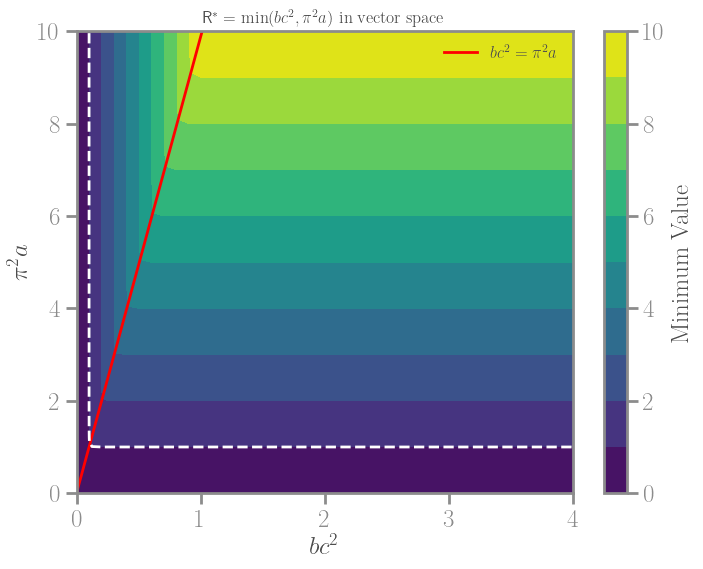

In [94]:

# Define the parameter ranges
bc_squared_values = np.linspace(0, 10, 100)
a_values = np.linspace(0, 10, 100)

# Create a meshgrid for the parameters
bc_squared, a = np.meshgrid(bc_squared_values, a_values)
# a, bc_squared = np.meshgrid(a_values, bc_squared_values)

# Compute the function value for each combination of parameters
result = np.minimum(bc_squared, np.pi**2 * a)

# Create a contour plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(a, bc_squared, result, cmap='viridis', levels=10)
plt.colorbar(contour, label='Minimum Value')
plt.plot(a_values, np.pi**2 * a_values, color='red', label=r'$bc^2 = \pi^2 a$')
plt.contour(a, bc_squared, result, levels=[1], colors='white', linestyles='dashed', label=r'$\mathsf{R}^*= 1$')

plt.ylim([0, 10])
plt.xlim([0, 4])

plt.xlabel(r'$bc^2$')
plt.ylabel(r'$\pi^2 a$')

plt.title(r'$\mathsf{R}^*= \min(bc^2, \pi^2 a)$ in vector space')

plt.legend()
# Show the plot
plt.show()

In [ ]:

# Define the parameter ranges
bc_squared_values = np.linspace(0, 10, 100)
a_values = np.linspace(0, 10, 100)

# Create a meshgrid for the parameters
bc_squared, a = np.meshgrid(bc_squared_values, a_values)
# a, bc_squared = np.meshgrid(a_values, bc_squared_values)

# Compute the function value for each combination of parameters
result = np.minimum(bc_squared, np.pi**2 * a)

# Create a contour plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(a, bc_squared, result, cmap='viridis', levels=10)
plt.colorbar(contour, label='Minimum Value')
plt.plot(a_values, np.pi**2 * a_values, color='red', label=r'$bc^2 = \pi^2 a$')
plt.contour(a, bc_squared, result, levels=[1], colors='white', linestyles='dashed', label=r'$\mathsf{R}^*= 1$')

plt.ylim([0, 10])
plt.xlim([0, 4])

plt.xlabel(r'$bc^2$')
plt.ylabel(r'$\pi^2 a$')

plt.title(r'$\mathsf{R}^*= \min(bc^2, \pi^2 a)$ in vector space')

plt.legend()
# Show the plot
plt.show()

## Phase space computations


In [65]:
import os
cwd = os.getcwd()
path_components = cwd.split(os.path.sep)
path_components = path_components[0:-2]
dirroot =  '/' + os.path.join(*path_components, 'test', 'output', 'rayleigh-benchmark', 'MPI-1')

!ls $dirroot


0d8834219758fd140ab651797b8d5b4a 6372095e0b1eaed14e123e64b9316bb0
0ff2e717134c5abbc534bd2533ff9da5 63c5c8c2f6acfa8286bc24001581c84b
13d6505ebc2b934521a5a502de43fce0 65a8c8fecbf3a3245fe56b0f15146662
17c366f102af831827f7f3f31bfa20c6 93666c80ed3523e3c2f7140d2788f85c
2f6fb02e066c6e61b2680447a53b61df a5890aa9faa3fdf524c243354051e794
322244626d33878ea33bbd8dc1e0b353 bef047fb68f6bc3b5feb6b2f634b15fc
397ca1ad1d81ed49d979170b8b651df1 ca594bc3492a497c7daf8ad2979efea3
5000476aa59dc0b1b99ce2037442e8be d7bd94f5b99ccb93acbdaaa53c030e83
5126c73c83a40d79ea28e777f96bbe9b e09ed3e3cf1b53277982e2db255b40ca
56de9d66f3d1c4cfbe7a47384bf0129b ff9c4acbaf25a77cb9e99342154bed50


In [20]:
successful_points = []
unsuccessful_points = []

for subdir, _, _ in os.walk(dirroot):
    parameters = load_parameters(subdir)
    if parameters is not None:
        a = parameters.get('model', {}).get('a')
        b = parameters.get('model', {}).get('b')
        c = parameters.get('model', {}).get('c')
        # Check if the computation is successful based on the existence of mode_shapes_data.npz
        success_file = os.path.join(subdir, 'mode_shapes_data.npz')
        if os.path.exists(success_file):
            successful_points.append((a, b*c**2))
        else:
            unsuccessful_points.append((a, b*c**2))


In [16]:
dirroot

'/Users/kumiori3/Documents/WIP/Nature/mec647/test/output/rayleigh-benchmark/MPI-1'

/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_91885/1220707274.py:7: RuntimeWarning: divide by zero encountered in divide
  return (np.pi**2 * a / (b * c**2))**(1/3)
/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_91885/1220707274.py:7: RuntimeWarning: invalid value encountered in divide
  return (np.pi**2 * a / (b * c**2))**(1/3)


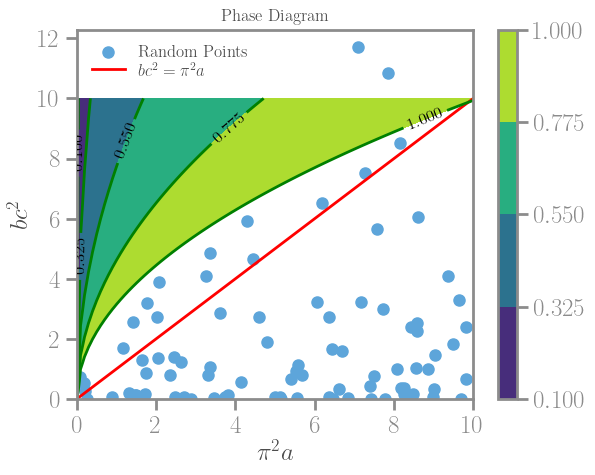

In [112]:
num_points = 100
points = [eig.book_of_the_numbers(scale_c=2, scale_b=3) for _ in range(num_points)]
x_values = [np.pi**2 * point["a"] for point in points]
y_values = [point["b"] * point["c"]**2 for point in points]

def compute_D(a, b, c):
    return (np.pi**2 * a / (b * c**2))**(1/3)

# Create a scatter plot
plt.scatter(x_values, y_values, label='Random Points')
plt.plot(np.linspace(0, 10), np.linspace(0, 10), color='red', label=r'$bc^2 = \pi^2 a$')


# Plot contour lines of the function D
a_values = np.linspace(0, 10, 100)
bc2_values = np.linspace(0, 10, 100)
A, BC2 = np.meshgrid(a_values, bc2_values)
D_values = compute_D(A, 1, BC2)  # Assuming b = 1 for simplicity
contour_lines = plt.contour(A, BC2, D_values, levels=np.linspace(.1, 1, 5), colors='green')
contourf = plt.contourf(A, BC2, D_values, levels=np.linspace(.1, 1, 5))
cbar = plt.colorbar(contourf)

plt.xlabel(r'$\pi^2 a$')
plt.ylabel(r'$b c^2$')
# plt.ylim([-3, 50])
plt.title('Phase Diagram')
plt.legend()


# Add contour labels
contour_labels = plt.clabel(contour_lines, inline=True, fontsize=12, colors='black')

# Add annotations for iso-D values
# for i, txt in enumerate(contour_labels):
    # plt.annotate(f'D={np.around(D_values[0, i], decimals=2)}', (txt.get_position()[0], txt.get_position()[1]))


In [52]:
compute_D(1, 1, 1)

2.1450293971110255

# Phase computation parametric

In [138]:
import os
cwd = os.getcwd()
path_components = cwd.split(os.path.sep)
path_components = path_components[0:-2]
dirroot =  '/' + os.path.join(*path_components, 'test', 'output', 'rayleigh-benchmark-parametric', 'MPI-1')

!ls $dirroot


0044f692a05422bb98c4bd3c6d04770c
00ffda65398984695ae5576fe383f02c
02bd5bbda8beff8f5cc0fbd88b599173
034189f38c18e6c04e59770762ddf137
043ebb377c5c5699e4d0c39a6efff1bd
046c79dade1d3ac0d860737fb091750e
04c979b82e2ec3add9a38959f42f52b1
06fd589cfddf7421b0f422bd92c4f077
0709aa4181151c6be88b7bcafc3e014c
08024b8d0f056a2e29555bbcff919b96
08c18d207e645c06bfbac1f997b0edad
0aa3df8dcb703508b12d1c306410ba06
0bd67cc936b53d779e505e7860e8d3a0
0bd72656f57f527e5863ef191c372831
0ce6d727b36b2329f0bbb7bbcdbedc32
0e5f3c92253e55d958c60f6c4b3c3c94
12e557a7aa59790b9b017adcc2d61778
133a813220736fd35ca5780e0704fc1f
14dffef10402801b89457241dc466ce3
154863f5eba04c9bd04c821204662c46
154b1d59bc43f05c208cd7e9315d48c9
182ec8780648c9a9ab4b05e10b28263a
186ab8e8139e59cdbddc72429ba378be
197773ce0c3bd5db1389a4e328fc1127
19c6e4fb5e77a4485581566f5ac85e7c
1a9321268f43fe71c8ad7f9ab0ffe154
1b32af79ec982846c16e8da2dece9111
1bde21d6d9e399af2546e2f9010b9350
1d99dc57effa20f609a0cf624bd5e04a
1da28d85e36e3d87bbd150884f1a6a4a
1dc98a04e2

In [139]:
successful_points = []
unsuccessful_points = []
data_for_plotting = []


for subdir, _, _ in os.walk(dirroot):
    parameters = load_parameters(subdir)
    signature = load_signature(subdir)
    if parameters is not None:
        a = parameters.get('model', {}).get('a')
        b = parameters.get('model', {}).get('b')
        c = parameters.get('model', {}).get('c')
    #     # Check if the computation is successful based on the existence of mode_shapes_data.npz
        success_file = os.path.join(subdir, 'mode_shapes_data.npz')
        if os.path.exists(success_file):
            successful_points.append((a, b*c**2))
            data = np.load(os.path.join(subdir, 'mode_shapes_data.npz'), allow_pickle=True)
            D_support = data['global_values'].item()['D_support']
            D_theory = data['global_values'].item()['D_theory']
            R_vector = data['global_values'].item()['R_vector']
            R_cone = data['global_values'].item()['R_cone']
            
            # Append data for plotting
            data_for_plotting.append({'pisq_a': np.pi**2*a, 'bc_squared': b*c**2, 'D_support': D_support, 'D_theory': D_theory, 
                                      'R_vector': R_vector, 'R_cone': R_cone, 'signature': signature})
            
        else:
            unsuccessful_points.append((a, b*c**2))
            data = []

In [140]:
D_theory_values = [point['D_theory'] for point in data_for_plotting]
D_support_values = [point['D_support'] for point in data_for_plotting]


/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_26783/4181458989.py:3: RuntimeWarning: divide by zero encountered in divide
  return (x / y)**(1/3)
/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_26783/4181458989.py:3: RuntimeWarning: invalid value encountered in divide
  return (x / y)**(1/3)


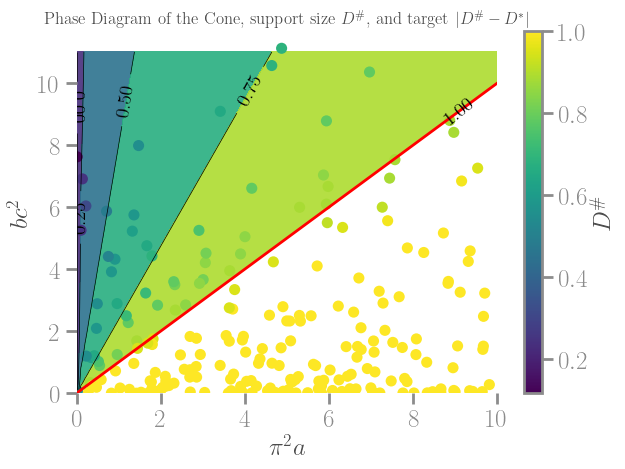

In [52]:
# Define the function
def func(x, y):
    return (x / y)**(1/3)

# Create a meshgrid
x = np.linspace(0, 10, 100)
y = np.linspace(0, 11, 100)
X, Y = np.meshgrid(x, y)

# Calculate the function values on the meshgrid
Z = func(X, Y)
plt.contourf(X, Y, Z, cmap='viridis', levels=np.linspace(0, 1, 5), alpha=.9)

D_theory_values = [point['D_theory'] for point in data_for_plotting]
D_support_values = [point['D_support'] for point in data_for_plotting]

x_values, y_values = zip(*[(point['pisq_a'], point['bc_squared']) for point in data_for_plotting])

# Create a scatter plot and color the points based on D_theory
scatter = plt.scatter(x_values, y_values, c=D_support_values, cmap='viridis', edgecolors='black', linewidths=.0, label='Data')

# error_values = [np.abs(float((point['D_support']-point['D_theory']))) for point in data_for_plotting]
# plt.errorbar(x_values, y_values, xerr=np.abs(error_values), yerr=np.abs(error_values), fmt='none', ecolor='red', alpha=0.9)
# Add a colorbar to the plot
cbar = plt.colorbar(scatter)
cbar.set_label('$D^\#$')
contour_lines = plt.contour(X, Y, Z, levels=np.linspace(0, 1, 5), colors='black', alpha=1, linestyles='solid', linewidths = .5)


# for i, (x, y, error) in enumerate(zip(x_values, y_values, error_values)):
#     if i % 5 == 0 and error !=0:  # Display error for every n-th point
#         plt.text(x, y, f'{error*100:.0f}\%', fontsize=8, ha='left', va='bottom')

plt.plot(np.linspace(0, 10), np.linspace(0, 10), color='red', label=r'$bc^2 = \pi^2 a$')

# manual_labels = {1.0: "$\pi^2 a = bc^2$"}  # Add labels for specific contour levels

contour_labels = plt.clabel(contour_lines, inline=True, fontsize=14, colors='black',
                            inline_spacing=10)

# Customize the spines
plt.gca().spines['top'].set_color('none')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['bottom'].set_color('none')
plt.gca().spines['left'].set_color('none')
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().yaxis.set_ticks_position('left')

# plt.xlim(0, 10)  # Replace with your desired limits
# plt.ylim(0, 10)  # Replace with your desired limits

# Set custom ticks
# plt.xticks(np.linspace(0, 10, 3))  # Replace with your desired tick positions
# plt.yticks(np.linspace(0, 10, 3))  # Replace with your desired tick positions

# plt.legend()
# Customize the plot
plt.xlabel('$\pi^2a$')
plt.ylabel('$bc^2$')
plt.title('Phase Diagram of the Cone, support size $D^\#$, and target $|D^\#-D^*|$')
# plt.show()
plt.tight_layout()
# plt.loglog()
plt.savefig('../../test/output/rayleigh-benchmark-parametric/phase_diagram.pdf', dpi=300)
plt.savefig('../../test/output/rayleigh-benchmark-parametric/phase_diagram.png', dpi=300)

In [40]:
# error_values = {'signature': np.abs(float((point['D_support']-point['D_theory']))) for point in data_for_plotting]
[(point.get('signature'), np.abs(float((point['D_support']-point['D_theory'])))) for point in data_for_plotting]

[('be93e3a1e3cd2893f62f838768340107', 0.0),
 ('55aa665af4383cdfab486497a526b948', 0.0),
 ('ae1a96698d6d1339b5ae36a9fc93a239', 0.0),
 ('9cfef1c0d73313a1414d49bc38ddeccf', 0.0),
 ('446276eafc7b7cb1df263d2d43575334', 0.0),
 ('ae03a35d8fe5b10029fb688ae9f08611', 0.013178100348074429),
 ('c2e711ccd4e5b1706d05d5bd98ef5a8e', 0.0),
 ('d323b3bd3f8ced38f7e5ed1370e95681', 0.0),
 ('0aa3df8dcb703508b12d1c306410ba06', 0.050000000000000044),
 ('818deb373f5d6257aa085493e2a12fb6', 0.0),
 ('39582b0fef781ef7dd59b969861740bb', 0.0),
 ('7021e9afc054e604d2e15dbc07a9db83', 0.0),
 ('c3066ac9a8f4a735e144494a06586074', 0.0),
 ('0bd67cc936b53d779e505e7860e8d3a0', 0.0),
 ('5f009deebc7c75e793bc5c2a3881177d', 0.10795092217091007),
 ('f5987d8fb47e09c39afd3e4aba484450', 0.0),
 ('7d21decc9d7b00098894bc65c19ccd48', 0.0),
 ('9f6e9f4b03f77f59fd59a719ce310950', 0.05374073117645395),
 ('1da28d85e36e3d87bbd150884f1a6a4a', 0.0),
 ('47724b1983ad0ec6fb3a085868e6406c', 0.0),
 ('d42c5f930bc58a9b85355978626be7d8', 0.0),
 ('046c79d

/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_26783/1541847198.py:3: RuntimeWarning: divide by zero encountered in divide
  return (x / y)**(1/3)
/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_26783/1541847198.py:3: RuntimeWarning: invalid value encountered in divide
  return (x / y)**(1/3)


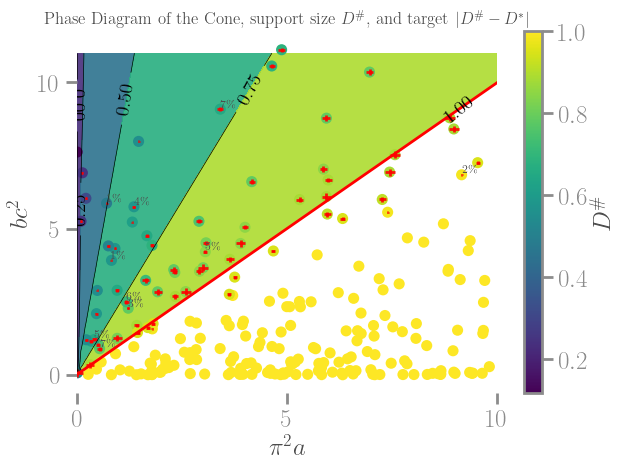

In [141]:
# Define the function
def func(x, y):
    return (x / y)**(1/3)

# Create a meshgrid
x = np.linspace(0, 10, 100)
y = np.linspace(0, 11, 100)
X, Y = np.meshgrid(x, y)

# Calculate the function values on the meshgrid
Z = func(X, Y)
plt.contourf(X, Y, Z, cmap='viridis', levels=np.linspace(0, 1, 5), alpha=.9)

D_theory_values = [point['D_theory'] for point in data_for_plotting]
D_support_values = [point['D_support'] for point in data_for_plotting]

x_values, y_values = zip(*[(point['pisq_a'], point['bc_squared']) for point in data_for_plotting])

# Create a scatter plot and color the points based on D_theory
scatter = plt.scatter(x_values, y_values, c=D_support_values, cmap='viridis', edgecolors='black', linewidths=.0, label='Data')

error_values = [np.abs(float((point['D_support']-point['D_theory']))) for point in data_for_plotting]
plt.errorbar(x_values, y_values, xerr=np.abs(error_values), yerr=np.abs(error_values), fmt='none', ecolor='red', alpha=0.9)
# Add a colorbar to the plot
cbar = plt.colorbar(scatter)
cbar.set_label('$D^\#$')
contour_lines = plt.contour(X, Y, Z, levels=np.linspace(0, 1, 5), colors='black', alpha=1, linestyles='solid', linewidths = .5)


for i, (x, y, error) in enumerate(zip(x_values, y_values, error_values)):
    if i % 5 == 0 and error !=0:  # Display error for every n-th point
        plt.text(x, y, f'{error*100:.0f}\%', fontsize=8, ha='left', va='bottom')

plt.plot(np.linspace(0, 10), np.linspace(0, 10), color='red', label=r'$bc^2 = \pi^2 a$')

# manual_labels = {1.0: "$\pi^2 a = bc^2$"}  # Add labels for specific contour levels

contour_labels = plt.clabel(contour_lines, inline=True, fontsize=14, colors='black',
                            inline_spacing=10)
                            # fmt=lambda x: manual_labels.get(x, str(x)))

# Customize the spines
plt.gca().spines['top'].set_color('none')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['bottom'].set_color('none')
plt.gca().spines['left'].set_color('none')
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().yaxis.set_ticks_position('left')

plt.xlim(0, 10)  # Replace with your desired limits
# plt.ylim(0, 10)  # Replace with your desired limits

# Set custom ticks
plt.xticks(np.linspace(0, 10, 3))  # Replace with your desired tick positions
plt.yticks(np.linspace(0, 10, 3))  # Replace with your desired tick positions

# plt.legend()
# Customize the plot
plt.xlabel('$\pi^2a$')
plt.ylabel('$bc^2$')
plt.title('Phase Diagram of the Cone, support size $D^\#$, and target $|D^\#-D^*|$')
# plt.show()
plt.tight_layout()
plt.savefig('../../test/output/rayleigh-benchmark-parametric/phase_diagram.pdf', dpi=300)
plt.savefig('../../test/output/rayleigh-benchmark-parametric/phase_diagram.png', dpi=300)

(0.011, 13)

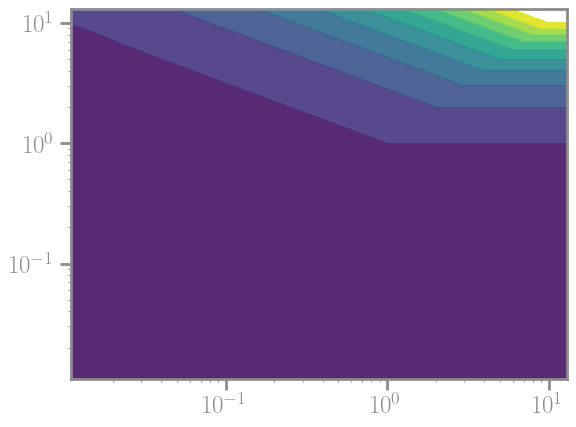

In [67]:
# Define the function
def func(x, y):
    # if y < x:
    #     return y
    # return (x)**(1/3)*(y)**(2/3)
    return np.where(y < x, y, x**(1/3) * y**(2/3))
    # return np.where(y < x, y, x)
x = np.linspace(0.01, 13, 1000)
y = np.linspace(0.01, 13, 1000)
X, Y = np.meshgrid(x, y)
Z = func(X, Y)
fig, ax = plt.subplots()

plt.contourf(X, Y, Z, cmap='viridis', levels=np.linspace(0, 10, 11), alpha=.9)
plt.loglog()
plt.xlim(0.011, 13)
plt.ylim(0.011, 13)

In [93]:
list(zip(x_values, y_values, error_values))

[(6.6773262696662155, 1.50623213137418, 0.00020288160064476035),
 (0.5858554005115375, 0.43622978385707767, 0.0003600187877919268),
 (6.5725237552898195, 0.025136313109886687, 3.2721098462563676e-06),
 (1.0354157820563092, 0.1668393672527919, 0.00014258604975576013),
 (7.056680595895529, 1.6834874059924716, 0.00021534171135360335),
 (0.8307622802137862, 3.9139966742282093, 0.01651081562037546),
 (8.46074712974943, 0.048551038121562196, 4.9116513394417655e-06),
 (6.304368339231937, 0.056147586387673636, 7.627982894806355e-06),
 (1.8189783463792775, 1.7496706289930286, 0.021733847875357773),
 (5.757838994127305, 0.3888519679277499, 5.857638606538939e-05),
 (9.669421459251927, 2.47727139602072, 0.00018916863883410628),
 (9.35245879360445, 4.587354403649845, 0.0003852331358685563),
 (5.065024796047362, 2.3272751740329074, 0.0002891752373693963),
 (2.6977773479489, 0.7562553860420645, 0.00010542976840857425),
 (5.936531237648591, 6.094500714234802, 0.048819902083972334),
 (5.573471143810648

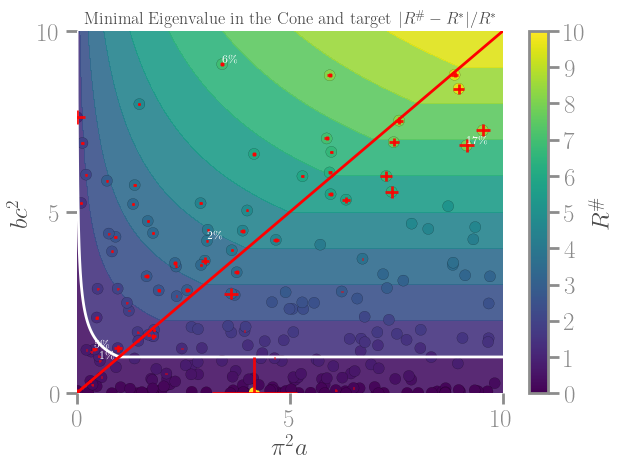

In [137]:
# Define the function
def func(x, y):
    # if y < x:
    #     return y
    # return (x)**(1/3)*(y)**(2/3)
    return np.where(y < x, y, x**(1/3) * y**(2/3))
    # return np.where(y < x, y, x)

# Create a meshgrid
x = np.linspace(0, 15, 1000)
y = np.linspace(0, 15, 1000)
X, Y = np.meshgrid(x, y)

# Calculate the function values on the meshgrid
Z = func(X, Y)
fig, ax = plt.subplots()

plt.contourf(X, Y, Z, cmap='viridis', levels=np.linspace(0, 10, 11), alpha=.9)

R_cone_values = [point['R_cone'] for point in data_for_plotting]

x_values, y_values = zip(*[(point['pisq_a'], point['bc_squared']) for point in data_for_plotting])

# Create a scatter plot and color the points based on D_theory
scatter = plt.scatter(x_values, y_values, c=R_cone_values, cmap='viridis', edgecolors='black', linewidths=.1, label='Data')

error_values = np.clip(np.abs([(point['R_cone'] - func(point['pisq_a'], point['bc_squared']).item())/func(point['pisq_a'], point['bc_squared']).item() 
                               for point in data_for_plotting]), 
                       0, 1)
# Add a colorbar to the plot
cbar = plt.colorbar(scatter, ticks=np.linspace(0, 10, 11))
scatter.colorbar.mappable.set_clim(0, 10)

cbar.set_label('$R^\#$')
contour_lines = plt.contour(X, Y, Z, levels=[1], colors='white', alpha=1, linestyles='solid', linewidths = 2)
contour_labels = plt.clabel(contour_lines, inline=True, fontsize=14, colors='white',
                            inline_spacing=10, fmt=lambda x: f"$R=$ {x:.0f}")

plt.plot(np.linspace(0, 10), np.linspace(0, 10), color='red', label=r'$bc^2 = \pi^2 a$')

plt.errorbar(x_values, y_values, yerr=error_values, xerr=error_values, fmt='none', ecolor='red', alpha=0.9)


for i, (x, y, error) in enumerate(zip(x_values, y_values, error_values)):
    if i % 10 == 0 and error > 1e-2:  # Display error for every n-th point
        plt.text(x, y, f'{error*100:.0f}\%', fontsize=8, ha='left', va='bottom', color='white')

# Customize the plot
plt.gca().spines['top'].set_color('none')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['bottom'].set_color('none')
plt.gca().spines['left'].set_color('none')
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().yaxis.set_ticks_position('left')

plt.xlim(0.0, 10)  # Replace with your desired limits
plt.ylim(0.0, 10)  # Replace with your desired limits


plt.xticks(np.linspace(0, 10, 3))  # Replace with your desired tick positions
plt.yticks(np.linspace(0, 10, 3))  # Replace with your desired tick positions

# plt.gca().dist = 105
# plt.subplots_adjust(bottom=1)
# ax.margins(0.05)
# plt.legend()
plt.xlabel('$\pi^2a$')
plt.ylabel('$bc^2$')
plt.title('Minimal Eigenvalue in the Cone and target $|R^\#-R^*|/R^*$')
plt.tight_layout()

# plt.loglog()


# plt.savefig('../../test/output/rayleigh-benchmark-parametric/phase_diagram_R_cone.pdf', dpi=300)
# plt.savefig('../../test/output/rayleigh-benchmark-parametric/phase_diagram_R_cone.png', dpi=300)

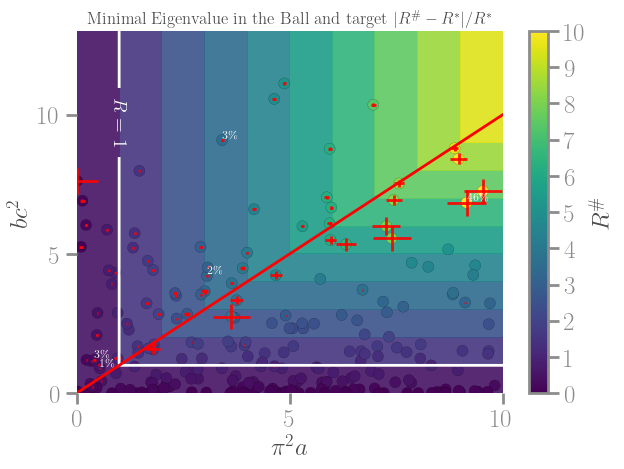

In [413]:
# Define the function
def func(x, y):
    return np.where(y < x, y, x)

# Create a meshgrid
x = np.linspace(0, 13, 100)
y = np.linspace(0, 13, 100)
X, Y = np.meshgrid(x, y)

# Calculate the function values on the meshgrid
Z = func(X, Y)
plt.contourf(X, Y, Z, cmap='viridis', levels=np.linspace(0, 10, 11), alpha=.9)

R_vector_values = [point['R_vector'] for point in data_for_plotting]

x_values, y_values = zip(*[(point['pisq_a'], point['bc_squared']) for point in data_for_plotting])

# Create a scatter plot and color the points based on D_theory
scatter = plt.scatter(x_values, y_values, c=R_vector_values, cmap='viridis', edgecolors='black', linewidths=.1, label='Data')

error_values = np.clip(np.abs([(point['R_vector'] - func(point['pisq_a'], point['bc_squared']).item())/func(point['pisq_a'], point['bc_squared']).item() for point in data_for_plotting]), 0, 3)
plt.errorbar(x_values, y_values, xerr=np.abs(error_values), yerr=np.abs(error_values), fmt='none', ecolor='red', alpha=0.9)
# Add a colorbar to the plot
cbar = plt.colorbar(scatter, ticks=np.linspace(0, 10, 11))
scatter.colorbar.mappable.set_clim(0, 10)

cbar.set_label('$R^\#$')
contour_lines = plt.contour(X, Y, Z, levels=[1], colors='white', alpha=1, linestyles='solid', linewidths = 2)

for i, (x, y, error) in enumerate(zip(x_values, y_values, error_values)):
    if i % 10 == 0 and error > 1e-3:  # Display error for every n-th point
        plt.text(x, y, f'{error*100:.0f}\%', fontsize=8, ha='left', va='bottom', color='white')

plt.plot(np.linspace(0, 10), np.linspace(0, 10), color='red', label=r'$bc^2 = \pi^2 a$')

# # manual_labels = {1.0: "$\pi^2 a = bc^2$"}  # Add labels for specific contour levels

contour_labels = plt.clabel(contour_lines, inline=True, fontsize=14, colors='white',
                            inline_spacing=10, fmt=lambda x: f"$R =$ {x:.0f}")
#                             # fmt=lambda x: manual_labels.get(x, str(x)))

# Customize the spines
plt.gca().spines['top'].set_color('none')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['bottom'].set_color('none')
plt.gca().spines['left'].set_color('none')
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().yaxis.set_ticks_position('left')

plt.xlim(0, 10)  # Replace with your desired limits
# plt.ylim(0, 10)  # Replace with your desired limits

# Set custom ticks
plt.xticks(np.linspace(0, 10, 3))  # Replace with your desired tick positions
plt.yticks(np.linspace(0, 10, 3))  # Replace with your desired tick positions

# plt.legend()
# Customize the plot
plt.xlabel('$\pi^2a$')
plt.ylabel('$bc^2$')
plt.title('Minimal Eigenvalue in the Ball and target $|R^\#-R^*|/R^*$')
# plt.show()
plt.tight_layout()
plt.savefig('../../test/output/rayleigh-benchmark-parametric/phase_diagram_R_ball.pdf', dpi=300)
plt.savefig('../../test/output/rayleigh-benchmark-parametric/phase_diagram_R_ball.png', dpi=300)

/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_91885/930303367.py:10: RuntimeWarning: divide by zero encountered in divide
  return (np.pi**2 * a / (bcsq))**(1/3)
/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_91885/930303367.py:10: RuntimeWarning: invalid value encountered in divide
  return (np.pi**2 * a / (bcsq))**(1/3)


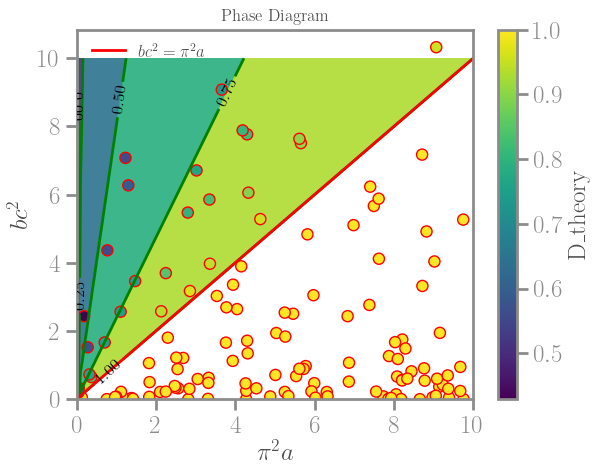

In [161]:
num_points = 100
points = [eig.book_of_the_numbers(scale_c=2, scale_b=3) for _ in range(num_points)]
x_values = [np.pi**2 * point["a"] for point in points]
y_values = [point["b"] * point["c"]**2 for point in points]

# def compute_D(a, b, c):
#     return (np.pi**2 * a / (b * c**2))**(1/3)

def compute_D(a, bcsq):
    return (np.pi**2 * a / (bcsq))**(1/3)

# Create a scatter plot

plt.contourf(X, Y, Z, cmap='viridis', levels=np.linspace(0, 1, 5), alpha=0.9)

# Plot contour lines of the function D
a_values = np.linspace(0, 10, 100)
bc2_values = np.linspace(0, 10, 100)
A, BC2 = np.meshgrid(a_values, bc2_values)
# D_values = compute_D(A, BC2)  # Assuming b = 1 for simplicity


contour_lines = plt.contour(X, Y, Z, levels=np.linspace(0, 1, 5), colors='green')
# contourf = plt.contourf(A, BC2, D_values, levels=np.linspace(0, 1, 5))


# cbar = plt.colorbar(contourf)

plt.plot(np.linspace(0, 10), np.linspace(0, 10), color='red', label=r'$bc^2 = \pi^2 a$')


plt.xlabel(r'$\pi^2 a$')
plt.ylabel(r'$b c^2$')
# plt.ylim([-3, 50])
plt.title('Phase Diagram')
plt.legend()


# plt.scatter(x_values, y_values, label='Random Points',edgecolors='black')
D_theory_values = [point['D_theory'] for point in data_for_plotting]
x_values, y_values = zip(*[(point['pisq_a'], point['bc_squared']) for point in data_for_plotting])

error_values = [float(point['D_support']-point['D_theory']) for point in data_for_plotting]


# Create a scatter plot and color the points based on D_theory
scatter = plt.scatter(x_values, y_values, c=D_theory_values, cmap='viridis', edgecolors='red')

plt.errorbar(x_values, y_values, xerr=error_values, yerr=error_values, fmt='none', ecolor='gray', alpha=0.5)

# Add a colorbar to the plot
cbar = plt.colorbar(scatter)
cbar.set_label('D_theory')



# Add contour labels
contour_labels = plt.clabel(contour_lines, inline=True, fontsize=12, colors='black')

# Add annotations for iso-D values
# for i, txt in enumerate(contour_labels):
    # plt.annotate(f'D={np.around(D_values[0, i], decimals=2)}', (txt.get_position()[0], txt.get_position()[1]))


In [165]:
D_support_values = [point['D_support'] for point in data_for_plotting]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_91885/2951459962.py:3: RuntimeWarning: divide by zero encountered in divide
  return (x / y)**(1/3)
/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_91885/2951459962.py:3: RuntimeWarning: invalid value encountered in divide
  return (x / y)**(1/3)


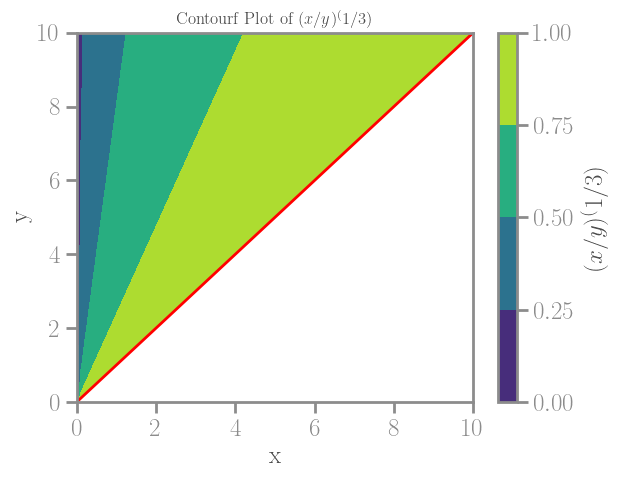

In [148]:
# Define the function
def func(x, y):
    return (x / y)**(1/3)

# Create a meshgrid
x = np.linspace(0, 10, 100)
y = np.linspace(0, 10, 100)
X, Y = np.meshgrid(x, y)

# Calculate the function values on the meshgrid
Z = func(X, Y)

# Create a filled contour plot
plt.contourf(X, Y, Z, cmap='viridis', levels=np.linspace(0, 1, 5))
plt.plot(np.linspace(0, 10), np.linspace(0, 10), color='red', label=r'$bc^2 = \pi^2 a$')

# Add a colorbar to the plot
cbar = plt.colorbar()
cbar.set_label('$(x/y)^(1/3)$')

# Customize the plot
plt.xlabel('x')
plt.ylabel('y')
plt.title('Contourf Plot of $(x/y)^(1/3)$')
plt.show()


### Cherry pick the profile

In [72]:
dirroot

'/Users/kumiori3/Documents/WIP/Nature/mec647/test/output/rayleigh-benchmark-parametric/MPI-1'

In [79]:
os.path.join(dirroot, f'profile_comparison-{signature}.pdf')

'/Users/kumiori3/Documents/WIP/Nature/mec647/test/output/rayleigh-benchmark-parametric/MPI-1/profile_comparison-2f6fb02e066c6e61b2680447a53b61df.pdf'

In [28]:
successful_points = []
unsuccessful_points = []
data_for_plotting = []


for subdir, _, _ in os.walk(dirroot):
    parameters = load_parameters(subdir)
    signature = load_signature(subdir)
    
    if signature is None:
        continue
    print(signature)

    if parameters is not None:
        a = parameters.get('model', {}).get('a')
        b = parameters.get('model', {}).get('b')
        c = parameters.get('model', {}).get('c')

        success_file = os.path.join(subdir, 'mode_shapes_data.npz')
        if os.path.exists(success_file):
            successful_points.append((a, b*c**2))
            modes_data = np.load(os.path.join(subdir, 'mode_shapes_data.npz'), allow_pickle=True)
            mode = pp.read_mode_data_from_npz(modes_data, time_step=0, num_modes=1, num_points=10)
            
            parameters = {"a": a, "b": b, "c": c}
            fig, ax = plot_profile_comparison(parameters, mode, idx=[1, 0], reverse=False)
            fig.savefig(os.path.join(subdir, 'profile_comparison.pdf'), dpi=300)
            fig.savefig(os.path.join(dirroot, f'profile_comparison-{signature}.pdf'), dpi=300)
            plt.close(fig)

be93e3a1e3cd2893f62f838768340107
case 1
[set(), {C}]
sqrt(C**2) False True
depends_on_C
case 1
sqrt(C**2)
depends_on_C
55aa665af4383cdfab486497a526b948
case 1
[set(), {C}]
sqrt(C**2) False True
depends_on_C
case 1
sqrt(C**2)
depends_on_C
ae1a96698d6d1339b5ae36a9fc93a239
case 1
[set(), {C}]
sqrt(C**2) False True
depends_on_C
case 1
sqrt(C**2)
depends_on_C
9cfef1c0d73313a1414d49bc38ddeccf
case 1
[set(), {C}]
sqrt(C**2) False True
depends_on_C
case 1
sqrt(C**2)
depends_on_C
446276eafc7b7cb1df263d2d43575334
case 1
[set(), {C}]
sqrt(C**2) False True
depends_on_C
case 1
sqrt(C**2)
depends_on_C
ae03a35d8fe5b10029fb688ae9f08611
case 2
[{x, A}, {x, A}]
1.0249981966475*sqrt(A**2/pi**2 + 0.475908872692863*A**2) True False
depends_on_A
case 2
sqrt(0.139045048633087*sin(1.0*pi**1.0)*cos(1.0*pi**1.0)/pi**0.333333333333333 + 0.139045048633087*pi**0.666666666666667*sin(1.0*pi**1.0)**2 + 0.556180194532348*sin(1.0*pi**1.0)/pi**0.333333333333333 + 0.139045048633087*pi**0.666666666666667*cos(1.0*pi**1.0)*

File 'time_data.json' not found. Handle this case accordingly.
case 2
[{x, A}, {x, A}]
sqrt(A**2/2 + 32*A**2/pi**2) True False
depends_on_A
case 2
sqrt(0.125*sin(1.0*pi**1.0)*cos(1.0*pi**1.0)/pi**0.333333333333333 + 0.125*pi**0.666666666666667*sin(1.0*pi**1.0)**2 + 0.5*sin(1.0*pi**1.0)/pi**0.333333333333333 + 0.125*pi**0.666666666666667*cos(1.0*pi**1.0)**2 + 0.25*pi**0.666666666666667)*sqrt(C**2)
depends_on_C


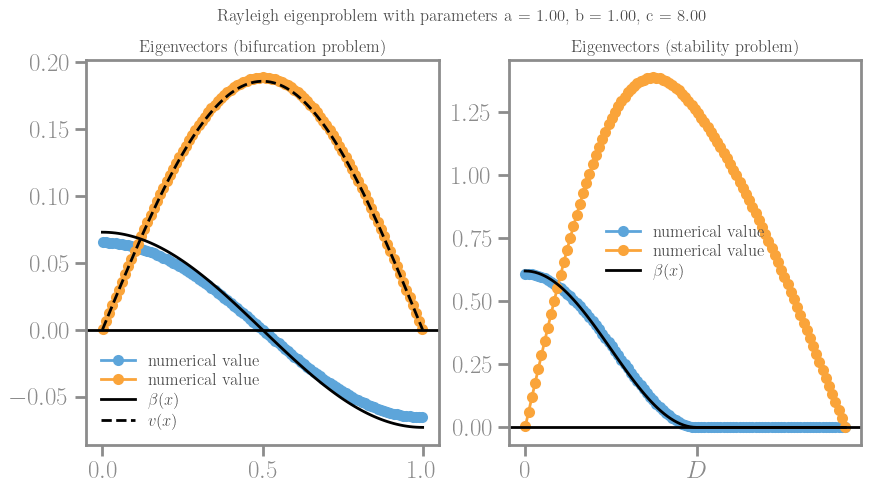

In [33]:
experiment = '../../test/output/rayleigh-benchmark/MPI-1/bef047fb68f6bc3b5feb6b2f634b15fc'
# experiment = '../../test/output/rayleigh-benchmark/MPI-1/93666c80ed3523e3c2f7140d2788f85c'

modes_data = np.load(os.path.join(experiment, 'mode_shapes_data.npz'), allow_pickle=True)
mode = pp.read_mode_data_from_npz(modes_data, time_step=0, num_modes=1, num_points=10)

params, data, signature = pp.load_data(experiment)

a = params['model']['a']
b = params['model']['b']
c = params['model']['c']

parameters = {"a": a, "b": b, "c": c}

plot_profile_comparison(parameters, mode, idx=[1, 0], reverse=False)

plt.savefig(os.path.join('../../test/output/rayleigh-benchmark/MPI-1', 'profile_comparison.pdf'), dpi=300)
plt.savefig(os.path.join('../../test/output/rayleigh-benchmark/MPI-1', 'profile_comparison.png'), dpi=300)


